In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.metrics import v_measure_score
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
!pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

In [2]:
train_df=pd.read_csv('mitbih_train.csv',header=None)
test_df=pd.read_csv('mitbih_test.csv',header=None)

c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

In [3]:
print(train_df.shape)
print(test_df.shape)

(87554, 188)
(21892, 188)


In [4]:
#garder uniquement 10'000 lignes de train_df
train_df=train_df.sample(10000)
print(train_df.shape)
print(test_df.shape)

(10000, 188)
(21892, 188)


c:\Users\antho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


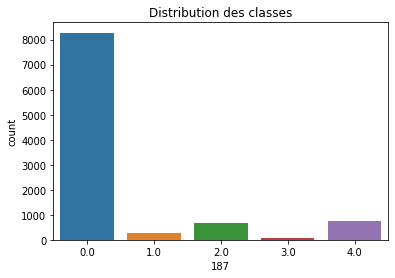

In [5]:
#montrer la distribution des classes
sns.countplot(train_df[187])
plt.title('Distribution des classes')
plt.show()

# Histogramm de la répartition

In [6]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)
test_df[187]=test_df[187].astype(int)
equilibre_test=test_df[187].value_counts()
print(equilibre_test)


0    8276
4     744
2     661
1     255
3      64
Name: 187, dtype: int64
0    18118
4     1608
2     1448
1      556
3      162
Name: 187, dtype: int64


affichage de la répartition par classe 

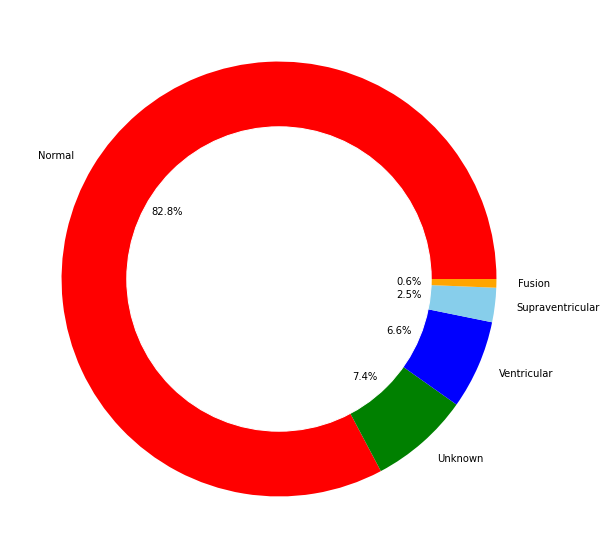

In [7]:
#-N : Non-ecotic beats (normal beat)
# -S : Supraventricular ectopic beats
# -V : Ventricular ectopic beats
# -F : Fusion Beats
# -Q : Unknown Beats
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['Normal','Unknown','Ventricular','Supraventricular','Fusion'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hist(class_number, size, min_, bins):
    img = train_df.loc[train_df[187] == class_number].values
    img = img[:, min_:size]
    img_flatten = img.flatten()

    final1 = np.arange(min_, size)
    for i in range(img.shape[0] - 1):
        tempo1 = np.arange(min_, size)
        final1 = np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    
    plt.hist2d(final1, img_flatten, bins=(bins, bins), cmap=plt.cm.jet)
    plt.colorbar() # Ajoute une barre de couleur pour mieux visualiser les intensités
    plt.clim(0, np.max(img_flatten)) # Ajuste la plage de couleurs pour améliorer le contraste
    plt.show()



1539336
1539336


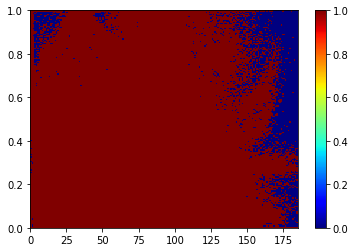

In [9]:
plot_hist(0, 186, 0, 186)

47430
47430


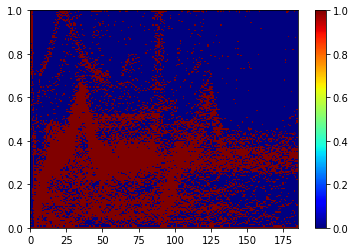

In [10]:
plot_hist(1, 186, 0, 186)

122946
122946


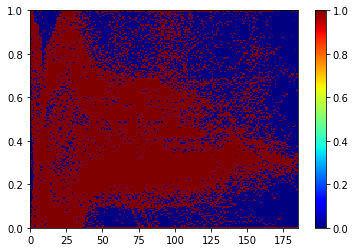

In [11]:
plot_hist(2, 186, 0, 186)

11904
11904


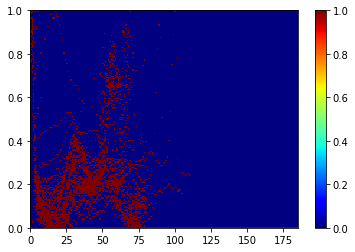

In [12]:
plot_hist(3, 186, 0, 186)

138384
138384


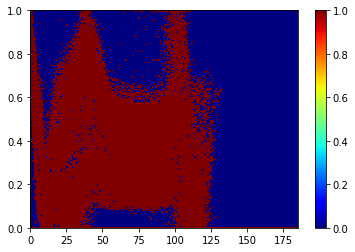

In [13]:
plot_hist(4, 186, 0, 186)

# Pre traitement

### Rééquilibrage ?

### Stockage des cibles

In [14]:
y_train=train_df[187].values
y_test=test_df[187].values

### Ajout de bruit ?

### Normalisation

In [15]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

# Scale time series
scaler = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_2D = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_test_scaled_2D = X_test_scaled.reshape(X_test_scaled.shape[0], -1)



X_train_r = X_train.reshape(len(X_train), X_train.shape[1])
X_test_r = X_test.reshape(len(X_test), X_test.shape[1])


TimeSeriesScalerMeanVariance prends en comptes les caractéristiques uniques des données de séries temporelles. (ce que ne fait pas un simple reshape) Ainsi, chaque série temp. contribue de manière égale à l'algorithme de regroupement

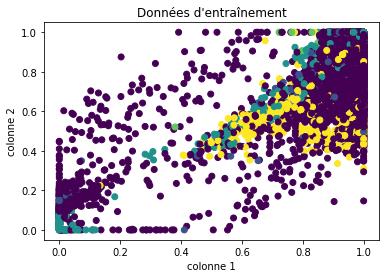

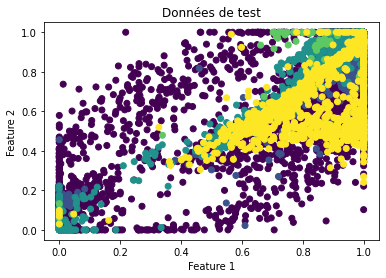

In [16]:
# Affichage des données d'entraînement
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.xlabel('colonne 1')
plt.ylabel('colonne 2')
plt.title('Données d\'entraînement')
plt.show()

# Affichage des données de test
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Données de test')
plt.show()

On peut voir que les regroupements sont difficiles pour ces données. 

# Clustering KMeans

In [17]:
from sklearn.metrics import confusion_matrix

V-measure: 0.08998080082257637
Indice de Rand ajusté : 0.10007593355843242


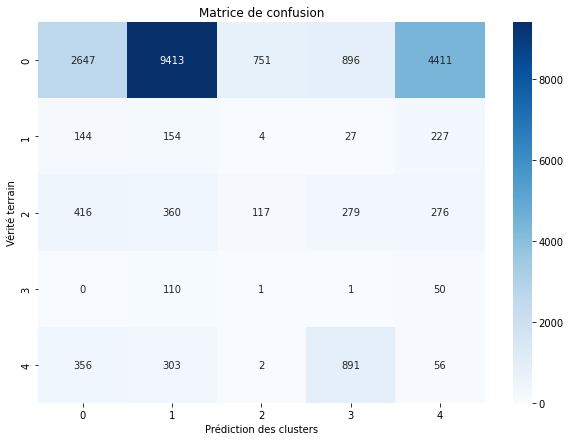

In [18]:
# Importer les bibliothèques nécessaires
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# définir le nombre de clusters
n_clusters = 5

# Initialiser le modèle KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Entraîner le modèle sur les données d'entraînement
kmeans.fit(X_train_r)

# Prédire les clusters pour les données de test
y_pred = kmeans.predict(X_test_r)

# Evaluer la performance en utilisant l'indice d'adjacent V-measure
v_measure = v_measure_score(y_test, y_pred)
print("V-measure:", v_measure)

# Calcul de l'indice de Rand ajusté
ari = adjusted_rand_score(y_test, y_pred)
print("Indice de Rand ajusté :", ari)

# Créer une matrice de confusion
confusion_mat = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion avec Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Prédiction des clusters')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()


In [19]:


# définir le nombre de clusters
n_clusters = 5

# Initialiser le modèle KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Entraîner le modèle sur les données d'entraînement
kmeans.fit(X_train_r)

# Prédire les clusters pour les données de test
y_pred = kmeans.predict(X_test_r)

# Evaluer la performance en utilisant l'indice d'adjacent V-measure

v_measure = v_measure_score(y_test, y_pred)
print("V-measure:", v_measure)


# Calcul de l'indice de Rand ajusté
ari = adjusted_rand_score(y_test, y_pred)

print("Indice de Rand ajusté :", ari)

V-measure: 0.08998080082257637
Indice de Rand ajusté : 0.10007593355843242


0.088 indique que les clusters formés ne sont pas très performants et qu'il est nécessaire de faire des ajustements supplémentaires pour améliorer la qualité du clustering. 0 min, 1 max pour des clusters parfait

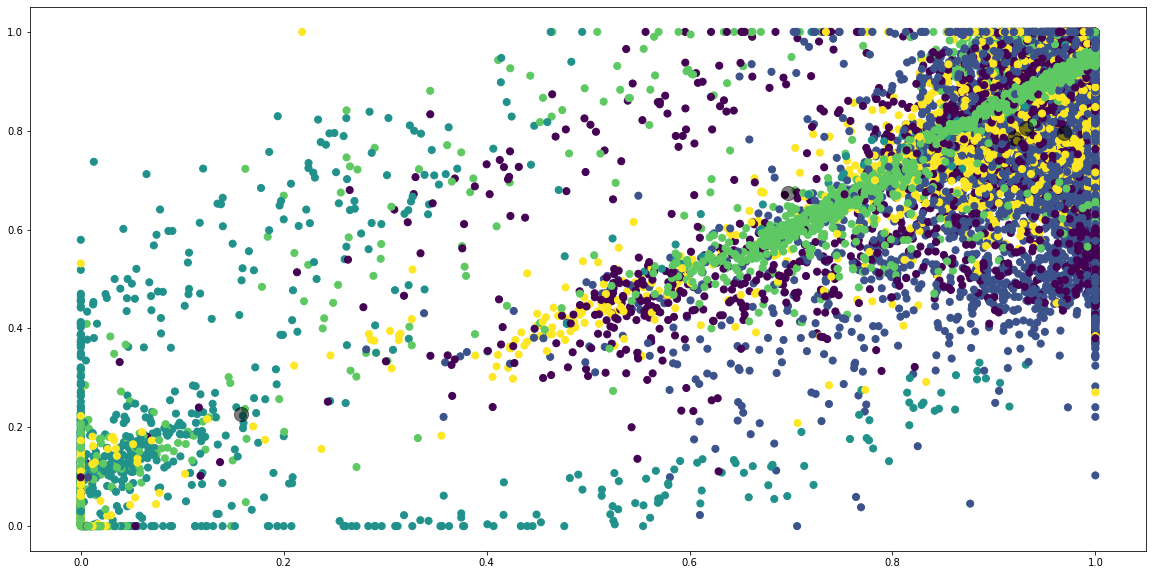

In [20]:
#plot the clusters
plt.figure(figsize=(20,10))
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()


In [21]:
# Évaluer les résultats avec le score de silhouette
silhouette_score_init = silhouette_score(X_test, y_pred)
print("Score de silhouette initial:",silhouette_score_init)

Score de silhouette initial: 0.17810756554545532


Pour la métrique silhouette, le min est -1 et le max 1. Plus le score est proche de 1, plus les clusters sont bien définis. Ici, le score initiale est 0.18.

In [22]:
#calculer le pourcentage de données mal classées
y_pred=kmeans.predict(X_test)
misclassified_samples=np.where(y_pred!=y_test)[0]
print("Pourcentage de données mal classées:",len(misclassified_samples)/len(y_test)*100)

Pourcentage de données mal classées: 86.41056093550155


In [23]:
from collections import Counter
import numpy as np

# Associez chaque cluster prédit à la classe la plus fréquente
cluster_to_class = {}
for cluster in range(n_clusters):
    cluster_indices = np.where(y_pred == cluster)[0]
    true_labels_in_cluster = y_test[cluster_indices]
    most_common_class = Counter(true_labels_in_cluster).most_common(1)[0][0]
    cluster_to_class[cluster] = most_common_class

# Calculez le nombre de données mal classées
misclassified_count = 0
for i in range(len(y_pred)):
    predicted_class = cluster_to_class[y_pred[i]]
    if predicted_class != y_test[i]:
        misclassified_count += 1

# Calculez le pourcentage de données mal classées
misclassification_rate = misclassified_count / len(y_test) * 100
print("Pourcentage de données mal classées en tenant compte des clusters les plus grands:", misclassification_rate)


Pourcentage de données mal classées en tenant compte des clusters les plus grands: 17.239174127535172


# Clustering KMeans temp - euclidean

In [24]:
# Time Series KMeans Clustering
n_clusters = 5
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", random_state=0)

# Fit the model on the training data
ts_kmeans.fit(X_train_scaled)

# Predict the clusters for the test data
y_pred = ts_kmeans.predict(X_test_scaled)

# Evaluate the results using the silhouette score
silhouette_score_tskmeans = silhouette_score(X_test_scaled.reshape(X_test.shape[0], -1), y_pred)
print("Silhouette score for Time Series KMeans:", silhouette_score_tskmeans)

# Calculating the percentage of misclassified data
misclassified_samples = np.where(y_pred != y_test)[0]
print("Percentage of misclassified data:", len(misclassified_samples) / len(y_test) * 100)

v_measure = v_measure_score(y_test, y_pred)
print("V-measure:", v_measure)

# Calcul de l'indice de Rand ajusté
ari = adjusted_rand_score(y_test, y_pred)

print("Indice de Rand ajusté :", ari)


Silhouette score for Time Series KMeans: 0.1209065176247146
Percentage of misclassified data: 79.81911200438516
V-measure: 0.07104125318907034
Indice de Rand ajusté : 0.006887514961862011


In [25]:
# Associez chaque cluster prédit à la classe la plus fréquente
cluster_to_class = {}
for cluster in range(n_clusters):
    cluster_indices = np.where(y_pred == cluster)[0]
    true_labels_in_cluster = y_test[cluster_indices]
    most_common_class = Counter(true_labels_in_cluster).most_common(1)[0][0]
    cluster_to_class[cluster] = most_common_class

# Calculez le nombre de données mal classées
misclassified_count = 0
for i in range(len(y_pred)):
    predicted_class = cluster_to_class[y_pred[i]]
    if predicted_class != y_test[i]:
        misclassified_count += 1

# Calculez le pourcentage de données mal classées
misclassification_rate = misclassified_count / len(y_test) * 100
print("Pourcentage de données mal classées en tenant compte des clusters les plus grands:", misclassification_rate)

Pourcentage de données mal classées en tenant compte des clusters les plus grands: 17.239174127535172


# Clustering KMeans temp - dtw

dtw est une autre métrique qui prend en compte les décalages temporels entre les séries temporelles.

In [26]:
n_clusters = 5
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)

# Fit the model on the training data
ts_kmeans.fit(X_train_scaled)   

# Predict the clusters for the test data
y_pred = ts_kmeans.predict(X_test_scaled)

silhouette_score_tskmeans = silhouette_score(X_test_scaled.reshape(X_test.shape[0], -1), y_pred)
print("Silhouette score for Time Series KMeans:", silhouette_score_tskmeans)

# Calculating the percentage of misclassified data
misclassified_samples = np.where(y_pred != y_test)[0]
print("Percentage of misclassified data:", len(misclassified_samples) / len(y_test) * 100)

v_measure = v_measure_score(y_test, y_pred)
print("V-measure:", v_measure)


KeyboardInterrupt: 

In [ ]:
# Calcul de l'indice de Rand ajusté
ari = adjusted_rand_score(y_test, y_pred)

print("Indice de Rand ajusté :", ari)

Indice de Rand ajusté : 0.03444724000133206


In [ ]:
# Associez chaque cluster prédit à la classe la plus fréquente
cluster_to_class = {}
for cluster in range(n_clusters):
    cluster_indices = np.where(y_pred == cluster)[0]
    true_labels_in_cluster = y_test[cluster_indices]
    most_common_class = Counter(true_labels_in_cluster).most_common(1)[0][0]
    cluster_to_class[cluster] = most_common_class

# Calculez le nombre de données mal classées
misclassified_count = 0
for i in range(len(y_pred)):
    predicted_class = cluster_to_class[y_pred[i]]
    if predicted_class != y_test[i]:
        misclassified_count += 1

# Calculez le pourcentage de données mal classées
misclassification_rate = misclassified_count / len(y_test) * 100
print("Pourcentage de données mal classées en tenant compte des clusters les plus grands:", misclassification_rate)

In [27]:
n_clusters = 5
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", random_state=0)

# Fit the model on the training data
ts_kmeans.fit(X_train_scaled)   

# Predict the clusters for the test data
y_pred = ts_kmeans.predict(X_test_scaled)

silhouette_score_tskmeans = silhouette_score(X_test_scaled.reshape(X_test.shape[0], -1), y_pred)
print("Silhouette score for Time Series KMeans:", silhouette_score_tskmeans)

# Calculating the percentage of misclassified data
misclassified_samples = np.where(y_pred != y_test)[0]
print("Percentage of misclassified data:", len(misclassified_samples) / len(y_test) * 100)

v_measure = v_measure_score(y_test, y_pred)
print("V-measure:", v_measure)


KeyboardInterrupt: 

In [ ]:
# Calcul de l'indice de Rand ajusté
ari = adjusted_rand_score(y_test, y_pred)

print("Indice de Rand ajusté :", ari)

Indice de Rand ajusté : 0.020643698006635246


In [ ]:
# Associez chaque cluster prédit à la classe la plus fréquente
cluster_to_class = {}
for cluster in range(n_clusters):
    cluster_indices = np.where(y_pred == cluster)[0]
    true_labels_in_cluster = y_test[cluster_indices]
    most_common_class = Counter(true_labels_in_cluster).most_common(1)[0][0]
    cluster_to_class[cluster] = most_common_class

# Calculez le nombre de données mal classées
misclassified_count = 0
for i in range(len(y_pred)):
    predicted_class = cluster_to_class[y_pred[i]]
    if predicted_class != y_test[i]:
        misclassified_count += 1

# Calculez le pourcentage de données mal classées
misclassification_rate = misclassified_count / len(y_test) * 100
print("Pourcentage de données mal classées en tenant compte des clusters les plus grands:", misclassification_rate)

# Clustering DBSCAN

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import silhouette_score
# from sklearn.cluster import DBSCAN

# # Define the range of values to test for epsilon and min_samples
# param_grid = {'eps': [0.1, 0.3, 0.5, 0.7, 0.9],
#               'min_samples': [100, 150, 200, 300,500]}

# # Define a function that creates an instance of DBSCAN and fits it to the data
# def dbscan_clustering(eps, min_samples):
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#     dbscan.fit(X_train_r)
#     labels = dbscan.labels_
#     return silhouette_score(X_train_r, labels)

# # Create a GridSearchCV object
# grid_search = GridSearchCV(estimator=dbscan_clustering, param_grid=param_grid, scoring='silhouette')

# # Fit the GridSearchCV object to the data
# grid_search.fit(X_train_r)

# # Print the best hyperparameters and the corresponding silhouette score
# print("Best hyperparameters:", grid_search.best_params_)
# print("Best silhouette score:", grid_search.best_score_)

# # Fit DBSCAN with the best hyperparameters
# dbscan = DBSCAN(eps=grid_search.best_params_['eps'], min_samples=grid_search.best_params_['min_samples'])
# dbscan.fit(X_train_r)

# # Predict the cluster labels for the test data
# y_pred = dbscan.fit_predict(X_test_r)

# # Calculate the adjusted Rand index if there are more than one clusters
# if len(np.unique(y_pred)) > 1:
#     ari = adjusted_rand_score(y_test, y_pred)
#     print("Adjusted Rand index:", ari)
# else:
#     print("Error: Only one cluster detected")


TypeError: estimator should be an estimator implementing 'fit' method, <function dbscan_clustering at 0x0000012B141218B0> was passed

In [ ]:
# Initialize the DBSCAN model
dbscan = DBSCAN(eps=0.3, min_samples=10)

# Fit the model to the data
dbscan.fit(X_train_r)

# Predict the cluster labels for the test data
y_pred = dbscan.fit_predict(X_test_r)

# Evaluer la performance en utilisant l'indice d'adjacent V-measure
v_measure = v_measure_score(y_test, y_pred)
print("V-measure:", v_measure)

# Evaluate the results using the silhouette score
silhouette_score_init = silhouette_score(X_test_r, y_pred)
print("Score de silhouette initial avec DBSCAN:", silhouette_score_init)

# Calculating the percentage of misclassified data
misclassified_samples = np.where(y_pred != y_test)[0]
print("Percentage of misclassified data:", len(misclassified_samples) / len(y_test) * 100)

# Calcul de l'indice de Rand ajusté
ari = adjusted_rand_score(y_test, y_pred)

print("Indice de Rand ajusté :", ari)


V-measure: 0.03328812026903625
Score de silhouette initial avec DBSCAN: -0.30481196525023657
Percentage of misclassified data: 98.2733418600402
Indice de Rand ajusté : -0.13054677936602122


In [ ]:
# Associez chaque cluster prédit à la classe la plus fréquente
cluster_to_class = {}
for cluster in range(n_clusters):
    cluster_indices = np.where(y_pred == cluster)[0]
    true_labels_in_cluster = y_test[cluster_indices]
    most_common_class = Counter(true_labels_in_cluster).most_common(1)[0][0]
    cluster_to_class[cluster] = most_common_class

# Calculez le nombre de données mal classées
misclassified_count = 0
for i in range(len(y_pred)):
    predicted_class = cluster_to_class[y_pred[i]]
    if predicted_class != y_test[i]:
        misclassified_count += 1

# Calculez le pourcentage de données mal classées
misclassification_rate = misclassified_count / len(y_test) * 100
print("Pourcentage de données mal classées en tenant compte des clusters les plus grands:", misclassification_rate)

# Clustering Shapelet

In [ ]:
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict

# Détermination des paramètres des shapelets
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=X_train_scaled.shape[0],
                                                       ts_sz=X_train_scaled.shape[1],
                                                       n_classes=len(np.unique(y_train)),
                                                       l=0.1,
                                                       r=2)

# Apprentissage du modèle de shapelets
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=0.01,
                        max_iter=200,
                        verbose=1,
                        random_state=0)
shp_clf.fit(X_train_scaled, y_train)

# Transformation des données en utilisant les shapelets appris
X_train_transformed = shp_clf.transform(X_train_scaled)
X_test_transformed = shp_clf.transform(X_test_scaled)

# Clustering avec K-means sur les données transformées
n_clusters = 5
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, random_state=0)

# Entraînement du modèle sur les données d'entraînement transformées
kmeans.fit(X_train_transformed)

# Prédiction des clusters pour les données de test transformées
y_pred = kmeans.predict(X_test_transformed)

# Evaluate the results using the silhouette score
silhouette_score_tskmeans = silhouette_score(X_test_scaled.reshape(X_test.shape[0], -1), y_pred)
print("Silhouette score for Time Series KMeans:", silhouette_score_tskmeans)

# Calculating the percentage of misclassified data
misclassified_samples = np.where(y_pred != y_test)[0]
print("Percentage of misclassified data:", len(misclassified_samples) / len(y_test) * 100)

v_measure = v_measure_score(y_test, y_pred)
print("V-measure:", v_measure)


# Calcul de l'indice de Rand ajusté
ari = adjusted_rand_score(y_test, y_pred)

print("Indice de Rand ajusté :", ari)

c:\Users\antho\anaconda3\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/200
40/40 [==============================] - 2s 16ms/step - loss: 1.6482 - categorical_accuracy: 0.2423 - categorical_crossentropy: 1.5827
Epoch 2/200
40/40 [==============================] - 1s 15ms/step - loss: 1.3054 - categorical_accuracy: 0.7663 - categorical_crossentropy: 1.2409
Epoch 3/200
40/40 [==============================] - 1s 14ms/step - loss: 1.0882 - categorical_accuracy: 0.8226 - categorical_crossentropy: 1.0238
Epoch 4/200
40/40 [==============================] - 1s 13ms/step - loss: 0.9564 - categorical_accuracy: 0.8242 - categorical_crossentropy: 0.8916
Epoch 5/200
40/40 [==============================] - 1s 14ms/step - loss: 0.8759 - categorical_accuracy: 0.8242 - categorical_crossentropy: 0.8106
Epoch 6/200
40/40 [==============================] - 1s 16ms/step - loss: 0.8255 - categorical_accuracy: 0.8242 - categorical_crossentropy: 0.7598
Epoch 7/200
40/40 [==============================] - 1s 14ms/step - loss: 0.7934 - categorical_accuracy: 0.8242 - cate

c:\Users\antho\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 21892 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


Silhouette score for Time Series KMeans: 0.011157696388188301
Percentage of misclassified data: 72.70692490407454
V-measure: 0.07396827011485446
Indice de Rand ajusté : -0.012005672130972414


In [ ]:
# Associez chaque cluster prédit à la classe la plus fréquente
cluster_to_class = {}
for cluster in range(n_clusters):
    cluster_indices = np.where(y_pred == cluster)[0]
    true_labels_in_cluster = y_test[cluster_indices]
    most_common_class = Counter(true_labels_in_cluster).most_common(1)[0][0]
    cluster_to_class[cluster] = most_common_class

# Calculez le nombre de données mal classées
misclassified_count = 0
for i in range(len(y_pred)):
    predicted_class = cluster_to_class[y_pred[i]]
    if predicted_class != y_test[i]:
        misclassified_count += 1

# Calculez le pourcentage de données mal classées
misclassification_rate = misclassified_count / len(y_test) * 100
print("Pourcentage de données mal classées en tenant compte des clusters les plus grands:", misclassification_rate)